# Financial Inclusion in Africa Starter Notebook


This notebook covers:
- Loading the data
- Data preprocessing and data wrangling
- Creating a simple model
- Making a submission


Importing Libraries

In [1]:
# dataframe and plotting
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# machine learning
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,f1_score, confusion_matrix, classification_report

#from google.colab import files
import warnings
warnings.filterwarnings('ignore')

## 1. Load the dataset

In [2]:
# Load files into a pandas dataframe
train = pd.read_csv('Train.csv')
test = pd.read_csv('Test.csv')
variables = pd.read_csv('VariableDefinitions.csv')

In [3]:
# Let’s observe the shape of our datasets.
print('train data shape :', train.shape)
train.head()

train data shape : (23524, 13)


,country,year,uniqueid,bank_account,location_type,cellphone_access,household_size,age_of_respondent,gender_of_respondent,relationship_with_head,marital_status,education_level,job_type
0,Kenya,2018,uniqueid_1,Yes,Rural,Yes,3,24,Female,Spouse,Married/Living together,Secondary education,Self employed
1,Kenya,2018,uniqueid_2,No,Rural,No,5,70,Female,Head of Household,Widowed,No formal education,Government Dependent
2,Kenya,2018,uniqueid_3,Yes,Urban,Yes,5,26,Male,Other relative,Single/Never Married,Vocational/Specialised training,Self employed
3,Kenya,2018,uniqueid_4,No,Rural,Yes,5,34,Female,Head of Household,Married/Living together,Primary education,Formally employed Private
4,Kenya,2018,uniqueid_5,No,Urban,No,8,26,Male,Child,Single/Never Married,Primary education,Informally employed


From the train data we observe we have 12 independent variables and 1 dependent variable which is our target 'bank_account'

In [4]:
print('test data shape :', test.shape)
test.head()

test data shape : (10086, 12)


,country,year,uniqueid,location_type,cellphone_access,household_size,age_of_respondent,gender_of_respondent,relationship_with_head,marital_status,education_level,job_type
0,Kenya,2018,uniqueid_6056,Urban,Yes,3,30,Male,Head of Household,Married/Living together,Secondary education,Formally employed Government
1,Kenya,2018,uniqueid_6060,Urban,Yes,7,51,Male,Head of Household,Married/Living together,Vocational/Specialised training,Formally employed Private
2,Kenya,2018,uniqueid_6065,Rural,No,3,77,Female,Parent,Married/Living together,No formal education,Remittance Dependent
3,Kenya,2018,uniqueid_6072,Rural,No,6,39,Female,Head of Household,Married/Living together,Primary education,Remittance Dependent
4,Kenya,2018,uniqueid_6073,Urban,No,3,16,Male,Child,Single/Never Married,Secondary education,Remittance Dependent


From the above we observe the test data to contain 12 independent variables

### 2. Data Preparation

Checking for missing values

In [5]:
# Check for missing values
print('missing values:', train.isnull().sum())

missing values: country                   0
year                      0
uniqueid                  0
bank_account              0
location_type             0
cellphone_access          0
household_size            0
age_of_respondent         0
gender_of_respondent      0
relationship_with_head    0
marital_status            0
education_level           0
job_type                  0
dtype: int64


Data Visualization

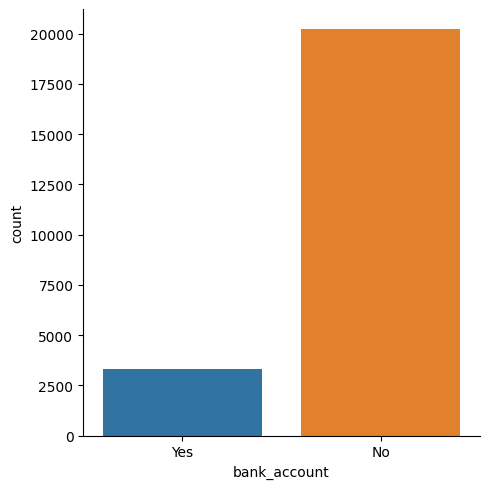

In [6]:
# Explore Target distribution 
sns.catplot(x="bank_account", kind="count", data=train)

Understanding The DataSet

Let us get more information about the data so as we can know how to deal with it

In [7]:
print(train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23524 entries, 0 to 23523
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   country                 23524 non-null  object
 1   year                    23524 non-null  int64 
 2   uniqueid                23524 non-null  object
 3   bank_account            23524 non-null  object
 4   location_type           23524 non-null  object
 5   cellphone_access        23524 non-null  object
 6   household_size          23524 non-null  int64 
 7   age_of_respondent       23524 non-null  int64 
 8   gender_of_respondent    23524 non-null  object
 9   relationship_with_head  23524 non-null  object
 10  marital_status          23524 non-null  object
 11  education_level         23524 non-null  object
 12  job_type                23524 non-null  object
dtypes: int64(3), object(10)
memory usage: 2.3+ MB
None


Spliting the data

The first step is to separate the independent variables and target(bank_account) from the train data. Then transform the target values from the object data type into numerical by using LabelEncoder.

In [8]:
#import preprocessing module
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
# Convert target label to numerical Data
le = LabelEncoder()
train['bank_account'] = le.fit_transform(train['bank_account'])
#Separate training features from target
X_train = train.drop(['bank_account'], axis=1)
y_train = train['bank_account']
print(y_train)

0        1
1        0
2        1
3        0
4        0
        ..
23519    0
23520    0
23521    0
23522    0
23523    0
Name: bank_account, Length: 23524, dtype: int32


The target values have been transformed into numerical datatypes, 1 represents ‘Yes’ and 0 represents ‘No’.

Let us use a preprocessing function to:

Handle conversion of data types
Convert categorical features to numerical features by using One-hot Encoder and Label Encoder
Drop uniqueid variable
Perform feature scaling.
The processing function will be used for both train and test independent variables.



In [9]:
# function to preprocess our data from train models
def preprocessing_data(data):

    # Convert the following numerical labels from interger to float
    float_array = data[["household_size", "age_of_respondent", "year"]].values.astype(float)
    
    # categorical features to be onverted to One Hot Encoding
    categ = ["relationship_with_head",
             "marital_status",
             "education_level",
             "job_type",
             "country"]
    
    # One Hot Encoding conversion
    data = pd.get_dummies(data, prefix_sep="_", columns=categ)
    
    # Label Encoder conversion
    data["location_type"] = le.fit_transform(data["location_type"])
    data["cellphone_access"] = le.fit_transform(data["cellphone_access"])
    data["gender_of_respondent"] = le.fit_transform(data["gender_of_respondent"])
    
    # drop uniquid column
    data = data.drop(["uniqueid"], axis=1)
    
    # scale our data into range of 0 and 1
    scaler = MinMaxScaler(feature_range=(0, 1))
    data = scaler.fit_transform(data)
    
    return data                  

Preprocess both train and test dataset.

In [10]:
# preprocess the train data 
processed_train = preprocessing_data(X_train)
processed_test = preprocessing_data(test)

In [11]:
print(processed_train)

[[1. 0. 1. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 1. 1. ... 0. 0. 0.]
 ...
 [1. 0. 1. ... 0. 0. 1.]
 [1. 1. 1. ... 0. 0. 1.]
 [1. 0. 1. ... 0. 0. 1.]]


Spliting the training data to obtain data that we are going to use to test the accuracy of our model

In [12]:
X_Train, X_Val, y_Train, y_val = train_test_split(processed_train, y_train, stratify = y_train,test_size = 0.1, random_state=42)

### 3. Choosing The Model

We are going to use Tree Based Models for our problem

In [13]:
# Decision Tree
dtree = tree.DecisionTreeClassifier()
dtree = dtree.fit(X_Train, y_Train)
# making prediction
result1 = dtree.predict(X_Val)

# Random Forest
rForest = RandomForestClassifier(n_estimators=10, criterion="entropy")
rForest = rForest.fit(X_Train, y_Train)
# making prediction
result2 = rForest.predict(X_Val)

# Gradient Boost
gbc = GradientBoostingClassifier(n_estimators=500, learning_rate=0.1, random_state=100)
gbc = gbc.fit(X_Train, y_Train)
# making prediction
result3 = gbc.predict(X_Val)

# XG Boost
xg_model = XGBClassifier()
xg_model = xg_model.fit(X_Train,y_Train)
# making prediction
result4 = xg_model.predict(X_Val)

#LightGBM Regressor
lgb = LGBMClassifier()
lgb = lgb.fit(X_Train,y_Train)
# making prediction
result5 = lgb.predict(X_Val)

### 5. Evaluating the model

Let us compare the performance of the models we selected

In [14]:
print(f'Accuracy of Decision Tree:', accuracy_score(y_val, result1))
print(f'f1_score of Decision Tree:', f1_score(y_val, result1))

print(f'Accuracy of Random Forest:', accuracy_score(y_val, result2))
print(f'f1_score of Random Forest:', f1_score(y_val, result2))

print(f'Accuracy of Gradient Boost:', accuracy_score(y_val, result3))
print(f'f1_score of Gradient Booste:', f1_score(y_val, result3))

print(f'Accuracy of XG Boost:', accuracy_score(y_val, result4))
print(f'f1_score of XG Boost:', f1_score(y_val, result4))

print(f'Accuracy of LGBM Regressor:', accuracy_score(y_val, result5))
print(f'f1_score of LGBM Regressor:', f1_score(y_val, result5))

Accuracy of Decision Tree: 0.8346791330216745
f1_score of Decision Tree: 0.4061068702290076
Accuracy of Random Forest: 0.8635784105397365
f1_score of Random Forest: 0.44367417677642984
Accuracy of Gradient Boost: 0.8878028049298767
f1_score of Gradient Booste: 0.47826086956521735
Accuracy of XG Boost: 0.8924776880577986
f1_score of XG Boost: 0.5217391304347826
Accuracy of LGBM Regressor: 0.894177645558861
f1_score of LGBM Regressor: 0.5146198830409358


For that case we are going to choose the LGBM Regressor which has a high accuracy and f1_score

In [15]:
# Classification Report of our LGBM Regressor model
print(classification_report(y_val, result5))

              precision    recall  f1-score   support

           0       0.91      0.98      0.94      2022
           1       0.73      0.40      0.51       331

    accuracy                           0.89      2353
   macro avg       0.82      0.69      0.73      2353
weighted avg       0.88      0.89      0.88      2353



## Making Experiment on test data

In [16]:
# Get the predicted result for the test Data
test.bank_account = lgb.predict(processed_test)

Then we create a submission file according to the instruction provided in the SubmissionFile.csv.

In [17]:
# Create submission DataFrame
submission = pd.DataFrame({"uniqueid": test["uniqueid"] + " x " + test["country"],
                           "bank_account": test.bank_account})

In [18]:
#show the five sample
submission.sample(5)

,uniqueid,bank_account
7761,uniqueid_8036 x Tanzania,0
1369,uniqueid_7438 x Kenya,0
1357,uniqueid_7426 x Kenya,1
2547,uniqueid_8616 x Kenya,1
5295,uniqueid_11430 x Rwanda,0


In [19]:
# Create submission csv file csv file
submission.to_csv('my_submission.csv', index = False)
open('my_submission.csv') 

<_io.TextIOWrapper name='my_submission.csv' mode='r' encoding='cp1252'>